# ECON 570: Final Project

# Evaluation of Job Training Program with Nonexperimental Data

Masashi Yoshioka (3200-3439-52), Jincen Jiang (XXXX-XXXX-XX), Shuxian Mao (6221-2815-32)

In [1]:
# Suppress warnings
# import warnings
# warnings.filterwarnings('ignore')

In [2]:
# Import basic functions
import numpy as np
import pandas as pd
import pyreadr
import random

# Import helper functions
from utils.functions import *

# Set random seeds
np.random.seed(570)
random.seed(570)

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

C:\Users\imym0\Anaconda3\envs\finance\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## 1. Introduction

a. What question are you answering with your project?  
b. Why should we care about this question?  
c. Have there been previous papers in the economics literature addressing this question? Summarize previous research briefly.

Draft by Shuxian:

Many literatures have been exploring whether non-experimental data can estimate treatment effects without bias. One way to evaluate econometric methods is to compare them with experimentally determined results. 

There are three main papers use data from the National Supported Work Demonstration experiment to study the performance of econometric estimators. 

Lalonde(1986) first uses data from a randomized evaluation program. He investigated the extent to which non-experimental estimates can replicate unbiased experimental estimates of treatment effects when applied to a combined dataset of experimental treatment units and non-experimental comparison units. He concluded that standard non-experimental estimation methods, such as regression, fixed effects, and potential variable selection models, are either inaccurate relative to experimental benchmarks or sensitive to the specifications used in regression. 

On the other hand, Dehejia and Wahba(1999) demonstrate the estimates of the training effect for Lalonde's hybrid of an experimental and non-experimental dataset are close to the benchmark experimental estimate when using propensity score methods. They conclude that although the method cannot account some important unobservable covariates, there are still substantial rewards in exploring first the information contained in the variables that are observed. 

However, when Simth and Todd(2005) applied the same methods to other reasonable samples from the NSW data which is different from DW used, the low bias results disappear. They discovered that the NSW impact estimates based on propensity score matching were very sensitive to both the variables included in the scores and the particular sample of analyses used in the estimates. They also found that the difference-in-difference match estimator performed best among cross-sectional matching, propensity score matching, and difference-in-difference estimation in all of their studies. Their findings show that while propensity score matching is a potentially useful econometric tool, it does not represent a general solution to the evaluation problem.

We focus on two questions and evaluate the experimental results of Lalonde and Dehejia through multiple methods. First, can we estimate causal effects in the National Supported Work (NSW) using nonexperimental data? Second, do the results differ between LaLonde (1986) dataset and Dehejia and Wahba (1999, 2002) subset? To answer the questions, we reproduces the methods of Lalonde (1986) and Dehejia and Wahba (1999) and adds a machine learning approach for comparison, and additionally applies the Inverse Probability of Treatment Weighting (IPTW) estimator and the double robust estimator to data from the National Supported Work (NSW) demonstration project.


## 2. Data

a. Describe the source(s) of the data  
b. Discuss whether you are removing any outliers from your data, or doing any other sampling restrictions  
c. Discuss whether you are transforming the data and/or merging/appending multiple datasets together  
d. Show comprehensive summary statistics.  
Remember: summary statistics are a very important part of all applied work!

### 2.1 The National Supported Work Demonstration

We use a dataset from the National Supported Work (NSW) Demonstration, which has been commonly used in the causal inference literature, including LaLonde (1986), Dehejia and Wahba (1999) and Smith and Todd (2005) as explained above. 

The NSW was a job training program conducted in the mid-1970s at 15 sites around the United States. Our dataset is focused on the program implemented in 10 sites from April 1975 to August 1977 among others. The program was targeted at 4 types of hard-to-employ people: female long-term AFDC<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1) recipients, ex-drug addicts, ex-climinal offenders and high school dropouts. The potential participants had to satisfy a set of eligibility criteria that included: (i) they must have been currently unemployed, (ii) they must have spent no more than 3 months on one regular job of at least 20 hours per week during the preceding 6 months, and so forth. These criteria as well as self-selection made the participants in NSW differ from the U.S. population in many characteristics.

The program operated as a randomized experiment by randomly assigning some applicants to a control group that was not allowed to participate in the program. For those assigned to the treatment group, the program guaranteed a job for 9 to 18 months, depending on the target group and site. The program paid the treatment group for their work, but the offered wage was lower than they would have received on a regular job. The participants were forced to find a regular job after their terms in the program expired.

The treatment and control groups were interviewed five times in total, one of which was a baseline and the others were follow-ups. Many people failed to complete these interviews and thus the sample attrition could have possibly caused biases. However, LaLonde (1986) suggests that the largest source of attrition, which is the interview schedule according to LaLonde (1986), should not affect the integrity of the experimental design because the interviews were randomly scheduled. Here we just assume that LaLonde (1986) is right and will not deal with the potential sample attrition problem. The interviews provide information on demographic characteristics, employment history, household income and so forth.

We are interested in the effect of the NSW on earnings of participants. Since the program randomly assigned applicants to treatment and control groups, the experimental data would presumably give us an unbiased estimate for the average treatment effect (ATE) of the program. LaLonde (1986) compared the experimental data with nonexperimental data such as Current Population Survey (CPS) and Panel Study of Income Dynamics (PSID), concluding that nonexperimental data fail to generate similar results to experimental data. Dehejia and Wahba (1999) concentrate on subsamples whose earnings in 1974 are available, and conclude that propensity-score matching would generate the results close to experimental design. Thus, our dataset consists of 6 different groups of samples: treatment group in LaLonde (1986), control group in LaLonde (1986), treatment subgroup in Dehejia and Wahba (1999), control subgroup in Dehejia and Wahba (1999), nonexperimental data from CPS and those from PSID. Using the dataset, we will see if nonexperimental data can generate estimates that are close enough to those given by experimental data.

### 2.2 Sample Restrictions

The datasets were retrieved from https://github.com/jjchern/lalonde/tree/master/data on February 2, 2022. Note that it only includes the male samples due to the data availability of LaLonde (1986). That is why Dehejia and Wahba (1999) and Smith and Todd (2005) also focus on males. This repository also includes the subsamples of CPS and PSID that were chosen by LaLonde (1986) to make them resemble the NSW applicants to the extent possible. However, according to Dehejia and Wahba (1999), choosing subsamples arbitrarily from the nonexperimental data would not improve the estimate. Thus, we will use the 6 groups described in 2.1 and discard subsamples of CPS and PSID. For the same reason, we will not do any sample restrictions including removing outliers from the data. Since the experiment was randomized, using all the samples would give an unbiased estimate of ATE. On the other hand, arbitrary sample restrictions can make treatment and control groups incomparable, which could cause a bias in the estimate.

### 2.3 Summary Statistics

First of all, we describe the summary statistics of each group below. The data includes the treatment status (`treat`), age (`age`), years of education (`education`), dummy for black (`black`), dummy for hispanic (`hispanic`), dummy for being married (`married`), dummy for dropout (`nodegree`), earnings in 1975 (`re75`) and in 1978 (`re78`). Note that the earnings in 1974 (`re74`) were not available for LaLonde (1986) experimental samples.

#### 2.3.1 LaLonde (1986) Experimental Data

In [3]:
# LaLonde's original dataset
df_nsw = pyreadr.read_r('./data/nsw.rda')['nsw']
df_nsw.head()

,data_id,treat,age,education,black,hispanic,married,nodegree,re75,re78
0,Lalonde Sample,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,9930.045898
1,Lalonde Sample,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,3595.894043
2,Lalonde Sample,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,24909.449219
3,Lalonde Sample,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0,7506.145996
4,Lalonde Sample,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,289.789886


In [4]:
# Treatment group in LaLonde (1986)
print('LaLonde Treatment Group')
df_nsw[df_nsw['treat'] == 1].describe().T

LaLonde Treatment Group


,count,mean,std,min,25%,50%,75%,max
treat,297.0,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.000000
age,297.0,24.626263,6.686391,17.0,20.000000,23.000000,27.000000,49.000000
education,297.0,10.380471,1.817712,4.0,9.000000,11.000000,12.000000,16.000000
black,297.0,0.801347,0.399660,0.0,1.000000,1.000000,1.000000,1.000000
hispanic,297.0,0.094276,0.292706,0.0,0.000000,0.000000,0.000000,1.000000
married,297.0,0.168350,0.374808,0.0,0.000000,0.000000,0.000000,1.000000
nodegree,297.0,0.730640,0.444376,0.0,0.000000,1.000000,1.000000,1.000000
re75,297.0,3066.098191,4874.888996,0.0,0.000000,1117.438965,4310.455078,37431.660156
re78,297.0,5976.352024,6923.796406,0.0,549.298401,4232.309082,9381.294922,60307.929688


In [5]:
# Control group in LaLonde (1986)
print('LaLonde Control Group')
df_nsw[df_nsw['treat'] == 0].describe().T

LaLonde Control Group


,count,mean,std,min,25%,50%,75%,max
treat,425.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
age,425.0,24.447059,6.590276,17.0,19.0,23.000000,28.000000,55.000000
education,425.0,10.188235,1.618686,3.0,9.0,10.000000,11.000000,14.000000
black,425.0,0.800000,0.400471,0.0,1.0,1.000000,1.000000,1.000000
hispanic,425.0,0.112941,0.316894,0.0,0.0,0.000000,0.000000,1.000000
married,425.0,0.157647,0.364839,0.0,0.0,0.000000,0.000000,1.000000
nodegree,425.0,0.814118,0.389470,0.0,1.0,1.000000,1.000000,1.000000
re75,425.0,3026.682756,5201.249820,0.0,0.0,823.254395,3649.769043,36941.269531
re78,425.0,5090.048301,5718.088763,0.0,0.0,3746.700928,8329.823242,39483.531250


We can see that the characteristics of treatment and control groups are quite similar to each other except `re78`, which is an outcome of the program. Each variable has a similar mean, standard deviation and so forth. Since the experiment was randomized, treatment and control groups should be comparable in pre-treatment variables. The above statistics are consistent with the randomized design.

#### 2.3.2 Dehejia and Wahba (1999) Experimental Data

In [6]:
# Dehejia and Wahba (1999) subsamples
df_nsw_dw = pyreadr.read_r('./data/nsw_dw.rda')['nsw_dw']
df_nsw_dw.head()

,data_id,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
0,Dehejia-Wahba Sample,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,0.0,9930.045898
1,Dehejia-Wahba Sample,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,0.0,3595.894043
2,Dehejia-Wahba Sample,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,24909.449219
3,Dehejia-Wahba Sample,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,7506.145996
4,Dehejia-Wahba Sample,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,0.0,289.789886


In [7]:
# Treatment group in Dehejia and Wahba (1999)
print('Dehejia and Wahba Treatment Group')
df_nsw_dw[df_nsw_dw['treat'] == 1].describe().T

Dehejia and Wahba Treatment Group


,count,mean,std,min,25%,50%,75%,max
treat,185.0,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.000000
age,185.0,25.816216,7.155019,17.0,20.000000,25.000000,29.000000,48.000000
education,185.0,10.345946,2.010650,4.0,9.000000,11.000000,12.000000,16.000000
black,185.0,0.843243,0.364558,0.0,1.000000,1.000000,1.000000,1.000000
hispanic,185.0,0.059459,0.237124,0.0,0.000000,0.000000,0.000000,1.000000
married,185.0,0.189189,0.392722,0.0,0.000000,0.000000,0.000000,1.000000
nodegree,185.0,0.708108,0.455867,0.0,0.000000,1.000000,1.000000,1.000000
re74,185.0,2095.573693,4886.620354,0.0,0.000000,0.000000,1291.468018,35040.070312
re75,185.0,1532.055313,3219.250879,0.0,0.000000,0.000000,1817.284058,25142.240234
re78,185.0,6349.143502,7867.402183,0.0,485.229797,4232.309082,9642.999023,60307.929688


In [8]:
# Control group in Dehejia and Wahba (1999)
print('Dehejia and Wahba Control Group')
df_nsw_dw[df_nsw_dw['treat'] == 0].describe().T

Dehejia and Wahba Control Group


,count,mean,std,min,25%,50%,75%,max
treat,260.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
age,260.0,25.053846,7.057745,17.0,19.0,24.000000,28.000000,55.000000
education,260.0,10.088462,1.614325,3.0,9.0,10.000000,11.000000,14.000000
black,260.0,0.826923,0.379043,0.0,1.0,1.000000,1.000000,1.000000
hispanic,260.0,0.107692,0.310589,0.0,0.0,0.000000,0.000000,1.000000
married,260.0,0.153846,0.361497,0.0,0.0,0.000000,0.000000,1.000000
nodegree,260.0,0.834615,0.372244,0.0,1.0,1.000000,1.000000,1.000000
re74,260.0,2107.026651,5687.905639,0.0,0.0,0.000000,139.424698,39570.679688
re75,260.0,1266.909015,3102.982088,0.0,0.0,0.000000,650.096451,23031.980469
re78,260.0,4554.801120,5483.836001,0.0,0.0,3138.795532,7288.420044,39483.531250


Compared to LaLonde (1986), some of the variables appear to show different distributions in Dehejia and Wahba (1999) datasets. For instance, earnings in 1975 (`re75`) of treatment group are higher than those of control group, although the difference does not appear to be statistically significant. By choosing only the samples whose earnings in 1974 are available, Dehejia and Wahba (1999) might have distorted the samples and hurt the comparability between treatment and control groups.

#### 2.3.3 Nonexperimental Data (CPS and PSID)

In [9]:
# CPS data
df_cps = pyreadr.read_r('./data/cps_controls.rda')['cps_controls']
df_cps.head()

,data_id,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
0,CPS1,0.0,45.0,11.0,0.0,0.0,1.0,1.0,21516.669922,25243.550781,25564.669922
1,CPS1,0.0,21.0,14.0,0.0,0.0,0.0,0.0,3175.970947,5852.564941,13496.080078
2,CPS1,0.0,38.0,12.0,0.0,0.0,1.0,0.0,23039.019531,25130.759766,25564.669922
3,CPS1,0.0,48.0,6.0,0.0,0.0,1.0,1.0,24994.369141,25243.550781,25564.669922
4,CPS1,0.0,18.0,8.0,0.0,0.0,1.0,1.0,1669.295044,10727.610352,9860.869141


In [10]:
print('CPS Control Group')
df_cps.describe().T

CPS Control Group


,count,mean,std,min,25%,50%,75%,max
treat,15992.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
age,15992.0,33.225238,11.045216,16.0,24.000000,31.000000,42.000000,55.000000
education,15992.0,12.027514,2.870846,0.0,11.000000,12.000000,13.000000,18.000000
black,15992.0,0.073537,0.261024,0.0,0.000000,0.000000,0.000000,1.000000
hispanic,15992.0,0.072036,0.258556,0.0,0.000000,0.000000,0.000000,1.000000
married,15992.0,0.711731,0.452971,0.0,0.000000,1.000000,1.000000,1.000000
nodegree,15992.0,0.295835,0.456432,0.0,0.000000,0.000000,1.000000,1.000000
re74,15992.0,14016.800360,9569.795964,0.0,4403.452393,15123.580078,23584.179688,25862.320312
re75,15992.0,13650.803522,9270.403408,0.0,4398.823242,14557.110352,22923.736816,25243.550781
re78,15992.0,14846.659650,9647.391501,0.0,5669.298096,16421.974609,25564.669922,25564.669922


In [11]:
# PSID data
df_psid = pyreadr.read_r('./data/psid_controls.rda')['psid_controls']
df_psid.head()

,data_id,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
0,PSID,0.0,47.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,PSID,0.0,50.0,12.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,PSID,0.0,44.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,PSID,0.0,28.0,12.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,PSID,0.0,54.0,12.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [12]:
print('PSID Control Group')
df_psid.describe().T

PSID Control Group


,count,mean,std,min,25%,50%,75%,max
treat,2490.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
age,2490.0,34.850602,10.440757,18.0,26.000000,33.000000,44.000000,55.000000
education,2490.0,12.116867,3.082435,0.0,11.000000,12.000000,14.000000,17.000000
black,2490.0,0.250602,0.433447,0.0,0.000000,0.000000,1.000000,1.000000
hispanic,2490.0,0.032530,0.177439,0.0,0.000000,0.000000,0.000000,1.000000
married,2490.0,0.866265,0.340436,0.0,1.000000,1.000000,1.000000,1.000000
nodegree,2490.0,0.305221,0.460593,0.0,0.000000,0.000000,1.000000,1.000000
re74,2490.0,19428.745805,13406.877171,0.0,10775.966797,18417.107422,26450.101562,137148.687500
re75,2490.0,19063.337668,13596.954865,0.0,9846.774414,17903.226562,26496.773438,156653.234375
re78,2490.0,21553.920924,15555.345539,0.0,11526.266602,20688.171875,29554.531250,121173.578125


The above statistics obviously show that neither CPS nor PSID samples are comparable with LaLonde treatment group or Dehejia and Wahba treatment group. For instance, samples in CPS are 33 years old and those in PSID are 35 years on average, whereas the average age of LaLonde and Deheija and Wahba treatment groups are 25-26. We will show the differences more graphically below. Before that, we append all the datasets for convenience.

In [13]:
# Combine all of the datasets
df_nsw.loc[df_nsw['treat'] == 1, 'data_id'] = 'LT'
df_nsw.loc[df_nsw['treat'] == 0, 'data_id'] = 'LC'
df_nsw_dw.loc[df_nsw_dw['treat'] == 1, 'data_id'] = 'DWT'
df_nsw_dw.loc[df_nsw_dw['treat'] == 0, 'data_id'] = 'DWC'
df_cps.data_id = 'CPS'

df = pd.concat([df_nsw, df_nsw_dw, df_cps, df_psid]).reset_index(drop = True)
df.data_id = pd.Categorical(df.data_id, ['LT', 'LC', 'DWT', 'DWC', 'CPS', 'PSID'])
df.head()

,data_id,treat,age,education,black,hispanic,married,nodegree,re75,re78,re74
0,LT,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,9930.045898,NaN
1,LT,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,3595.894043,NaN
2,LT,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,24909.449219,NaN
3,LT,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0,7506.145996,NaN
4,LT,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,289.789886,NaN


We also define a varaible `dif` which represents the difference between `re78` and `re75`.

In [14]:
# Add a difference in revenues
df['dif'] = df['re78'] - df['re75']
df

,data_id,treat,age,education,black,hispanic,married,nodegree,re75,re78,re74,dif
0,LT,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.000000,9930.045898,NaN,9930.045898
1,LT,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.000000,3595.894043,NaN,3595.894043
2,LT,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.000000,24909.449219,NaN,24909.449219
3,LT,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.000000,7506.145996,NaN,7506.145996
4,LT,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.000000,289.789886,NaN,289.789886
...,...,...,...,...,...,...,...,...,...,...,...,...
19644,PSID,0.0,47.0,8.0,0.0,0.0,1.0,1.0,33837.097656,38568.664062,44667.363281,4731.566406
19645,PSID,0.0,32.0,8.0,0.0,0.0,1.0,1.0,67137.093750,59109.062500,47022.402344,-8028.031250
19646,PSID,0.0,47.0,10.0,0.0,0.0,1.0,1.0,47968.113281,55710.292969,48197.964844,7742.179688
19647,PSID,0.0,54.0,0.0,0.0,1.0,1.0,1.0,44220.968750,20540.398438,49228.539062,-23680.570312


#### 2.3.4 Comparisons

To make clearer the differences in sample groups, we will further show various statistics below.

##### Conditional Mean

In [15]:
# Conditional mean
df.groupby('data_id').mean().T

data_id,LT,LC,DWT,DWC,CPS,PSID
treat,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
age,24.626263,24.447059,25.816216,25.053846,33.225238,34.850602
education,10.380471,10.188235,10.345946,10.088462,12.027514,12.116867
black,0.801347,0.800000,0.843243,0.826923,0.073537,0.250602
hispanic,0.094276,0.112941,0.059459,0.107692,0.072036,0.032530
married,0.168350,0.157647,0.189189,0.153846,0.711731,0.866265
nodegree,0.730640,0.814118,0.708108,0.834615,0.295835,0.305221
re75,3066.098191,3026.682756,1532.055313,1266.909015,13650.803522,19063.337668
re78,5976.352024,5090.048301,6349.143502,4554.801120,14846.659650,21553.920924
re74,NaN,NaN,2095.573693,2107.026651,14016.800360,19428.745805


The above table shows the conditional mean of each characteristic. We can see that the NSW experimental data are totally different from CPS and PSID. As we have already seen above, the average age is much lower in the NSW data than in CPS/PSID. In addition, compared to CPS/PSID, the NSW samples have the lower average year of education, much more black people, more hispanic people, more singles and more dropouts. These differences are not surprising considering the eligibility criteria for the NSW. Moreover, the average earnings of the NSW samples are much lower than those of CPS/PSID. Therefore, it is obvious that taking differences between experimental treatment group and *nonexperimental* control group would not provide a good estimate of the effect of the program.

##### Boxplot

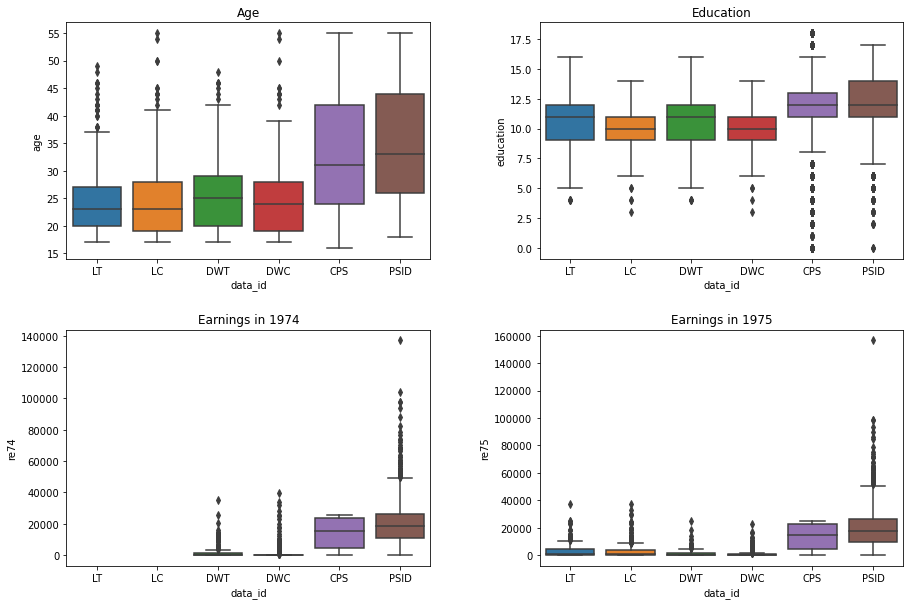

In [16]:
# Boxplots
fn_boxplots(df = df)

The above boxplots show the distributions of pre-treatment continuous variables within each group. Again, it is obvious that the NSW samples are totally different from CPS/PSID in all the characteristics. In order to estimate the ATE from the nonexperimental data, we should take these differences into consideration.

## 3. Modeling

a. Analyze the data using 2-3 different model specifications (i.e. with/without covariates, using different definitions of the treatment, outcome, or predictor variables, etc.)  
Remember: complicated models are not necessarily better than simple models. There is nothing wrong with OLS regression if that’s the best model.

### 3.1 Regression

Under the assumption of unconfoundedness $Y_0, Y_1 \perp D | X$, we can obtain the average treatment effect by

$$
\begin{align*}
ATE &= E[Y_1 - Y_0] \\
    &= E_X[E[Y_1 - Y_0 | X]] \\
    &= E_X[E[Y_1|X] - E[Y_0 | X]] \\
    &= E_X[E[Y_1|X, D=1] - E[Y_0 | X, D=0]] \\
    &= E_X[E[Y|X, D=1] - E[Y|X, D=0]]. \\
\end{align*}
$$

In this section, we try to estimate $\mu_1 (X) \equiv E[Y | D = 1, X]$ and $\mu_0 (X) \equiv E[Y | D = 0, X]$ using different regression models: i) Linear regression, ii) Random Forest regression and iii) Gradient Boosting regression. 

#### 3.1.1 Linear Regression

Here, we assume $E[Y|D, X] = \alpha + \tau D + X \beta + u$. Then, we obtain $E[Y|D = 1, X] - E[Y|D = 0, X] = \tau$, which in turn implies $ATE = \tau$.

In [17]:
# Obtain a 'true' average treatment effects
fn_regression_result(outcome = 'dif', treat_id = 'LT', control_id = 'LC', df = df)

Dependent Variable: Difference between 1975 and 1978
Treatment: LaLonde
Control: LaLonde


,Without control,With age,With all control
treat,846.8883,856.9110,819.2771
,(560.1417),(557.6783),(561.4912)
age,,-703.6823***,-746.4430***
,,(241.6312),(251.1351)
age2,,11.5827***,12.3287***
,,(4.0793),(4.2293)
black,,,77.0276
,,,(956.0357)
education,,,87.1087
,,,(217.5539)


The coefficient on `treat` is the estimate for ATE. We can see that it is stable and around 800&ndash;900 when we use LaLonde's original dataset.

In [18]:
# Obtain a 'true' average treatment effects over the DW subset
fn_regression_result(outcome = 'dif', treat_id = 'DWT', control_id = 'DWC', df = df)

Dependent Variable: Difference between 1975 and 1978
Treatment: Dehejia and Wahba
Control: Dehejia and Wahba


,Without control,With age,With all control
treat,1529.1961**,1516.9969**,1375.1516**
,(679.5380),(682.2371),(688.3945)
age,,-46.6970,-182.7710
,,(279.9331),(288.1882)
age2,,1.1926,3.4888
,,(4.6231),(4.7521)
black,,,-1688.9039
,,,(1260.7920)
education,,,282.9176
,,,(247.4508)


Notably, the ATE estimate is much larger than LaLonde's original data. It is about 1,300&ndash;1,600.

Now, we try to obtain these results using nonexperimental data. First, we compare LaLonde treatment dataset and CPS/PSID. If the unconfoundedness holds and our specification $E[Y|D, X] = \alpha + \tau D + X \beta + u$ is correct, we should be able to get similar results even when using CPS/PSID.

In [19]:
# Obtain nonexperimental treatment effects over LaLonde treatment and CPS
fn_regression_result(outcome = 'dif', treat_id = 'LT', control_id = 'CPS', df = df)

Dependent Variable: Difference between 1975 and 1978
Treatment: LaLonde
Control: CPS


,Without control,With age,With all control
treat,1714.3977***,195.1746,237.6512
,(452.2939),(441.8344),(472.5252)
age,,-561.3006***,-552.4132***
,,(36.6097),(37.9290)
age2,,5.7530***,5.6575***
,,(0.5158),(0.5365)
black,,,-183.2507
,,,(225.2557)
education,,,111.4728***
,,,(30.5601)


In [20]:
# Obtain nonexperimental treatment effects over LaLonde treatment and PSID
fn_regression_result(outcome = 'dif', treat_id = 'LT', control_id = 'PSID', df = df)

Dependent Variable: Difference between 1975 and 1978
Treatment: LaLonde
Control: PSID


,Without control,With age,With all control
treat,419.6706,-749.2072,-443.6768
,(650.5836),(691.9516),(758.4989)
age,,25.8463,-29.5044
,,(154.1027),(154.8596)
age2,,-2.1310,-1.1350
,,(2.1075),(2.1258)
black,,,-3.7683
,,,(501.7495)
education,,,342.0243***
,,,(103.8807)


Compared to the true treatment effect of LaLonde's data, the treatment effects generated from nonexperimental data of CPS and PSID vary largely in different controlling conditions, and they fail to generate similar results to experimental data.  

We apply the same methods to DW dataset. The following table summarizes the results.

In [21]:
# Summarize the linear regression results
reg_summary_dif = fn_regression_summary(df = df, outcome = 'dif')
reg_summary_dif

,Outcome,Treatment,Control,Without control,With age,With all control
0,dif,LT,LC,846.888287,856.910955,819.277091
1,dif,LT,CPS,1714.397705,195.174602,237.651169
2,dif,LT,PSID,419.670577,-749.207210,-443.676772
3,dif,DWT,DWC,1529.196083,1516.996931,1375.151605
4,dif,DWT,CPS,3621.232061,2383.311533,2490.625993
5,dif,DWT,PSID,2326.504934,1256.927930,1724.284500


The treatment effects from nonexperiment data fail to generate similar results of DW's experiment results.  

We also use the earnings in 1978 as the dependent variable. The following table presents the results.

In [22]:
# Summarize the linear regression results for earnings in 1978
reg_summary_re78 = fn_regression_summary(df = df, outcome = 're78')
reg_summary_re78

,Outcome,Treatment,Control,Without control,With age,With all control
0,re78,LT,LC,886.303722,881.739626,798.351154
1,re78,LT,CPS,-8870.307627,-7172.308044,-4416.211594
2,re78,LT,PSID,-15577.568900,-13267.657059,-8067.322113
3,re78,DWT,DWC,1794.342382,1736.057724,1672.426452
4,re78,DWT,CPS,-8497.516148,-7274.306837,-4416.872715
5,re78,DWT,PSID,-15204.777421,-13268.950367,-7741.075140


The choice of the dependent variable greatly affects the results whereas we have got the similar results using experimental data.  

Here we conclude that linear regression fails to generate experimental results by nonexperimental data. That is possibly because (i) unconfoundedness fails to hold or (ii) a linear specification is wrong. We will apply other regression methods to see if (ii) is true. Note that unconfoundedness is not testable.

#### 3.1.2 Random Forest Regression

Now we estimate $\mu_d (X = x) = f(d, x)$ by Random Forest. First, we fit $Y = f(D, X)$ by Random Forest and get the estimator $\hat{f}(D, X)$. Then, the ATE estimate is given by the sample average of $\hat{f}(1, X) - \hat{f}(0, X)$.

<!-- It is well known that the Random Forest often performs well for prediction. The Random Forest can predict the non-linear relationship between dependent and independent variables, so we expect that it can potentially give us nonexperimental estimates that are closer to experimental ones. The hyperparameters are tuned by cross validation. -->

In [23]:
param_grid = {'n_estimators': [50, 100, 500, 1000],
              'max_features': [2, 3, 4, 5]}

RF_summary = fn_ML_results(df = df, method = 'RF', param_grid = param_grid)
RF_summary[RF_summary.Outcome == 'dif'].reset_index(drop = True)

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [24:32<00:00, 736.48s/it]


,Outcome,Treatment,Control,Method,Est_Imput,ATE
0,dif,LT,LC,Regression,RF,1050.745880
1,dif,LT,CPS,Regression,RF,2827.125271
2,dif,LT,PSID,Regression,RF,677.994351
3,dif,DWT,DWC,Regression,RF,1192.891451
4,dif,DWT,CPS,Regression,RF,4147.130516
5,dif,DWT,PSID,Regression,RF,2421.435178


In [24]:
RF_summary[RF_summary.Outcome == 're78'].reset_index(drop = True)

,Outcome,Treatment,Control,Method,Est_Imput,ATE
0,re78,LT,LC,Regression,RF,995.759953
1,re78,LT,CPS,Regression,RF,-3669.878382
2,re78,LT,PSID,Regression,RF,-7809.572183
3,re78,DWT,DWC,Regression,RF,1495.568156
4,re78,DWT,CPS,Regression,RF,-3342.364456
5,re78,DWT,PSID,Regression,RF,-7461.962243


#### 3.1.3 Gradient Boosting Regression
Estimate $\mu_d (X) \equiv E[Y|D = d, X]$ by Gradient Boosting.

In [25]:
param_grid = {'n_estimators': [50, 100, 500, 1000],
              'max_features': [2, 3, 4, 5]}

GB_summary = fn_ML_results(df = df, method = 'GB', param_grid = param_grid)
GB_summary[GB_summary.Outcome == 'dif'].reset_index(drop = True)

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [08:01<00:00, 240.68s/it]


,Outcome,Treatment,Control,Method,Est_Imput,ATE
0,dif,LT,LC,Regression,GB,769.596407
1,dif,LT,CPS,Regression,GB,2168.816546
2,dif,LT,PSID,Regression,GB,615.406169
3,dif,DWT,DWC,Regression,GB,1189.304675
4,dif,DWT,CPS,Regression,GB,3646.448022
5,dif,DWT,PSID,Regression,GB,2587.054168


In [26]:
GB_summary[GB_summary.Outcome == 're78'].reset_index(drop = True)

,Outcome,Treatment,Control,Method,Est_Imput,ATE
0,re78,LT,LC,Regression,GB,696.425647
1,re78,LT,CPS,Regression,GB,-4141.430741
2,re78,LT,PSID,Regression,GB,-7781.724026
3,re78,DWT,DWC,Regression,GB,1363.019006
4,re78,DWT,CPS,Regression,GB,-3560.804552
5,re78,DWT,PSID,Regression,GB,-8879.187004


### 3.2 Propensity Score Matching

#### 3.2.1 Estimate propensity score by logistic regression

LaLonde dataset

In [27]:
df_LT_CPS = fn_generate_data(treat_id = 'LT', control_id = 'CPS', df = df)
X, T = fn_generate_variables(outcome = None, df = df_LT_CPS)
phat_logit_LT_CPS = fn_propensity_score(X, T, method = 'logit')

df_matched = fn_generate_df_matched(df = df_LT_CPS, prop = phat_logit_LT_CPS, outcome = 'dif',
                                    n_neighbors = 1, caliper = np.inf)
df_matched.head(10)

,data_id,treat,age,education,black,hispanic,married,nodegree,re75,re78,dif,propensity_score,propensity_score_logit,matched_index_1,matched_outcome_1,distance_1,matched_outcome_average
0,LT,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,9930.045898,9930.045898,0.213584,-1.303455,1543.0,0.000000,0.010222,0.000000
1,LT,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,3595.894043,3595.894043,0.137609,-1.835291,1234.0,2611.256226,0.000079,2611.256226
2,LT,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,24909.449219,24909.449219,0.247696,-1.110939,531.0,1898.879028,0.000000,1898.879028
3,LT,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0,7506.145996,7506.145996,0.540837,0.163711,2161.0,-519.932495,0.001348,-519.932495
4,LT,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,289.789886,289.789886,0.458722,-0.165489,2533.0,3695.935547,0.008529,3695.935547
5,LT,1.0,22.0,9.0,1.0,0.0,0.0,1.0,0.0,4056.493896,4056.493896,0.537262,0.149326,909.0,7919.249878,0.000079,7919.249878
6,LT,1.0,23.0,12.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.278597,-0.951431,420.0,12538.509766,0.000000,12538.509766
7,LT,1.0,32.0,11.0,1.0,0.0,0.0,1.0,0.0,8472.158203,8472.158203,0.512442,0.049777,729.0,22859.492920,0.004648,22859.492920
8,LT,1.0,22.0,16.0,1.0,0.0,0.0,0.0,0.0,2164.021973,2164.021973,0.338048,-0.672006,1126.0,116.740402,0.000000,116.740402
9,LT,1.0,19.0,9.0,1.0,0.0,0.0,1.0,0.0,8173.908203,8173.908203,0.554208,0.217686,1812.0,0.000000,0.000000,0.000000


See how comparable the treatment and control groups have become by the propensity score matching.

In [28]:
# Conditional mean
df_matched_treat = fn_generate_df_matched_treat(df_matched = df_matched, treat_id = 'LT')
fn_mean_by_group(df_matched_treat = df_matched_treat, treat_id = 'LT')

data_id,CPS,LT
treat,0.000000,1.000000
age,25.097473,24.440433
education,10.552347,10.292419
black,0.884477,0.859206
hispanic,0.086643,0.093863
married,0.133574,0.155235
nodegree,0.696751,0.768953
re75,3094.071600,2870.036685
re78,6308.649275,5942.459912
dif,3214.577675,3072.423227


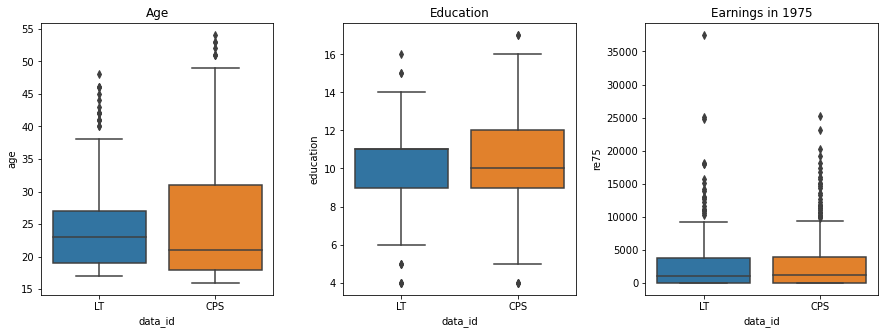

In [29]:
# Boxplots
fn_boxplots(df = df_matched_treat, re74 = False)

PSID

In [30]:
df_LT_PSID = fn_generate_data(treat_id = 'LT', control_id = 'PSID', df = df)
X, T = fn_generate_variables(outcome = None, df = df_LT_PSID)
phat_logit_LT_PSID = fn_propensity_score(X, T, method = 'logit')

df_matched = fn_generate_df_matched(df = df_LT_PSID, prop = phat_logit_LT_PSID, outcome = 'dif',
                                    n_neighbors = 1, caliper = np.inf)

df_matched_treat = fn_generate_df_matched_treat(df_matched = df_matched, treat_id = 'LT')
fn_mean_by_group(df_matched_treat = df_matched_treat, treat_id = 'LT')

data_id,LT,PSID
treat,1.000000,0.000000
age,24.513605,24.312925
education,10.394558,10.435374
black,0.802721,0.826531
hispanic,0.095238,0.105442
married,0.163265,0.156463
nodegree,0.727891,0.690476
re75,2859.766375,3233.145989
re78,5958.267558,7001.418233
dif,3098.501184,3768.272243


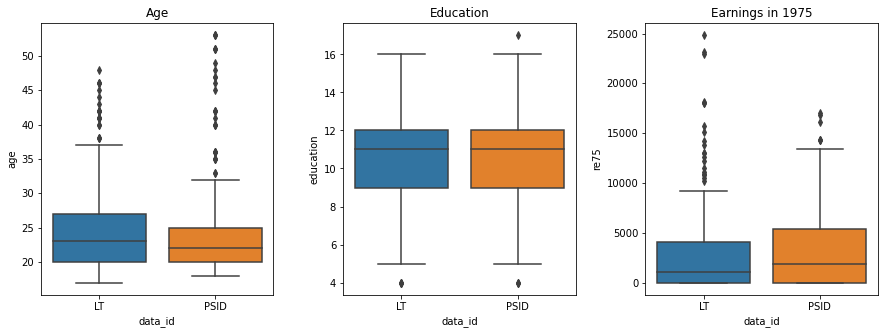

In [31]:
# Boxplots
fn_boxplots(df = df_matched_treat, re74 = False)

How about DW dataset?

In [32]:
df_DWT_CPS = fn_generate_data(treat_id = 'DWT', control_id = 'CPS', df = df)
X, T = fn_generate_variables(outcome = None, df = df_DWT_CPS)
phat_logit_DWT_CPS = fn_propensity_score(X, T, method = 'logit')

df_matched = fn_generate_df_matched(df = df_DWT_CPS, prop = phat_logit_DWT_CPS, outcome = 'dif',
                                    n_neighbors = 1, caliper = np.inf)

df_matched_treat = fn_generate_df_matched_treat(df_matched = df_matched, treat_id = 'DWT')
fn_mean_by_group(df_matched_treat = df_matched_treat, treat_id = 'DWT')

data_id,CPS,DWT
treat,0.000000,1.000000
age,24.493976,25.620482
education,10.500000,10.216867
black,0.927711,0.915663
hispanic,0.036145,0.048193
married,0.156627,0.156627
nodegree,0.680723,0.746988
re75,945.376631,1053.871833
re78,5246.258639,6004.840528
re74,1668.480926,1676.139672


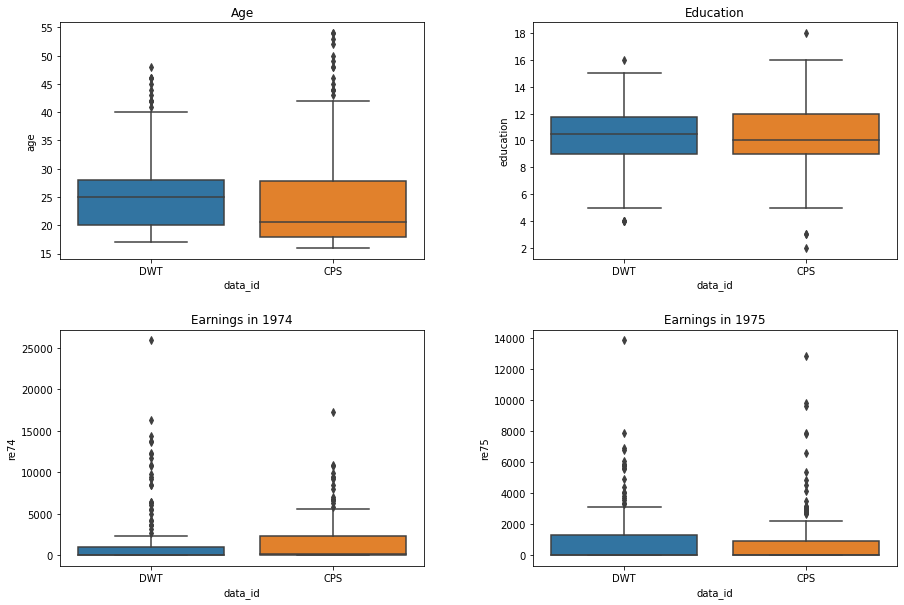

In [33]:
# Boxplots
fn_boxplots(df = df_matched_treat, re74 = True)

In [34]:
df_DWT_PSID = fn_generate_data(treat_id = 'DWT', control_id = 'PSID', df = df)
X, T = fn_generate_variables(outcome = None, df = df_DWT_PSID)
phat_logit_DWT_PSID = fn_propensity_score(X, T, method = 'logit')

df_matched = fn_generate_df_matched(df = df_DWT_PSID, prop = phat_logit_DWT_PSID, outcome = 'dif',
                                    n_neighbors = 1, caliper = np.inf)

df_matched_treat = fn_generate_df_matched_treat(df_matched = df_matched, treat_id = 'DWT')
fn_mean_by_group(df_matched_treat = df_matched_treat, treat_id = 'DWT')

data_id,DWT,PSID
treat,1.000000,0.000000
age,25.638889,25.033333
education,10.333333,10.455556
black,0.838889,0.888889
hispanic,0.061111,0.038889
married,0.166667,0.127778
nodegree,0.711111,0.727778
re75,1133.351571,1735.041407
re78,6117.885886,5943.539499
re74,1613.143910,3981.415164


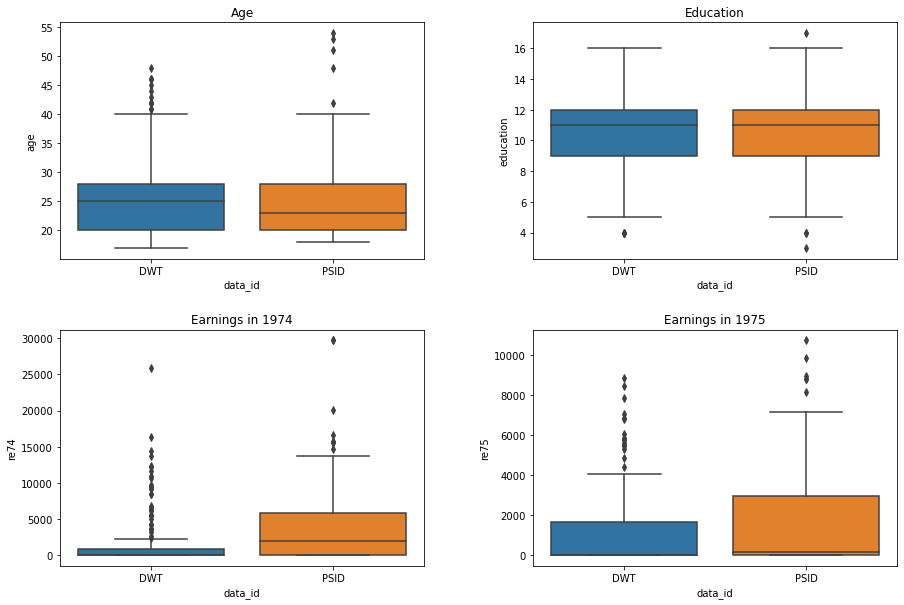

In [35]:
# Boxplots
fn_boxplots(df = df_matched_treat, re74 = True)

Better than LaLonde?

#### 3.2.2 Estimate propensity score by Random Forest

LaLonde dataset

In [36]:
X, T = fn_generate_variables(outcome = None, df = df_LT_CPS)

param_grid = {'n_estimators': [50, 100, 500, 1000],
              'max_features': [2, 3, 4, 5]}

phat_RF_LT_CPS = fn_propensity_score(X, T, method = 'RF', param_grid = param_grid)

df_matched = fn_generate_df_matched(df = df_LT_CPS, prop = phat_RF_LT_CPS, outcome = 'dif',
                                    n_neighbors = 1, caliper = np.inf)

df_matched.head(10)

,data_id,treat,age,education,black,hispanic,married,nodegree,re75,re78,dif,propensity_score,propensity_score_logit,matched_index_1,matched_outcome_1,distance_1,matched_outcome_average
0,LT,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,9930.045898,9930.045898,0.650696,0.622102,742.0,0.000000,0.063345,0.000000
1,LT,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,3595.894043,3595.894043,0.726200,0.975428,742.0,0.000000,0.289981,0.000000
2,LT,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,24909.449219,24909.449219,0.320433,-0.751781,378.0,1898.879028,0.000000,1898.879028
3,LT,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,289.789886,289.789886,0.797000,1.367649,742.0,0.000000,0.682202,0.000000
4,LT,1.0,22.0,9.0,1.0,0.0,0.0,1.0,0.0,4056.493896,4056.493896,0.879333,1.986132,742.0,0.000000,1.300685,0.000000
5,LT,1.0,23.0,12.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.333478,-0.692498,337.0,12538.509766,0.000000,12538.509766
6,LT,1.0,32.0,11.0,1.0,0.0,0.0,1.0,0.0,8472.158203,8472.158203,0.841105,1.666471,742.0,0.000000,0.981024,0.000000
7,LT,1.0,22.0,16.0,1.0,0.0,0.0,0.0,0.0,2164.021973,2164.021973,0.430720,-0.278913,584.0,116.740402,0.000000,116.740402
8,LT,1.0,33.0,12.0,0.0,0.0,1.0,0.0,0.0,12418.070312,12418.070312,0.064238,-2.678767,320.0,0.000000,0.000000,0.000000
9,LT,1.0,19.0,9.0,1.0,0.0,0.0,1.0,0.0,8173.908203,8173.908203,0.526742,0.107069,856.0,0.000000,0.000000,0.000000


In [37]:
# Conditional mean
df_matched_treat = fn_generate_df_matched_treat(df_matched = df_matched, treat_id = 'LT')
fn_mean_by_group(df_matched_treat = df_matched_treat, treat_id = 'LT')

data_id,CPS,LT
treat,0.000000,1.000000
age,17.728522,24.587629
education,10.123711,10.371134
black,0.979381,0.797251
hispanic,0.000000,0.096220
married,0.013746,0.171821
nodegree,0.955326,0.725086
re75,0.000000,3120.781137
re78,381.177304,6012.680913
dif,381.177304,2891.899776


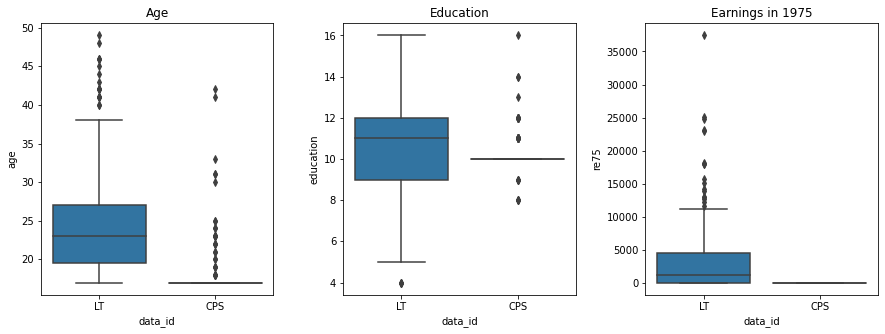

In [38]:
# Boxplots
fn_boxplots(df = df_matched_treat, re74 = False)

In [39]:
X, T = fn_generate_variables(outcome = None, df = df_LT_PSID)

phat_RF_LT_PSID = fn_propensity_score(X, T, method = 'RF', param_grid = param_grid)

df_matched = fn_generate_df_matched(df = df_LT_PSID, prop = phat_RF_LT_PSID, outcome = 'dif',
                                    n_neighbors = 1, caliper = np.inf)

df_matched_treat = fn_generate_df_matched_treat(df_matched = df_matched, treat_id = 'LT')
fn_mean_by_group(df_matched_treat = df_matched_treat, treat_id = 'LT')

data_id,LT,PSID
treat,1.000000,0.000000
age,25.429134,24.153543
education,10.433071,11.791339
black,0.775591,0.992126
hispanic,0.102362,0.000000
married,0.196850,0.011811
nodegree,0.712598,0.216535
re75,3491.992634,0.000000
re78,5970.222188,1224.040490
dif,2478.229554,1224.040490


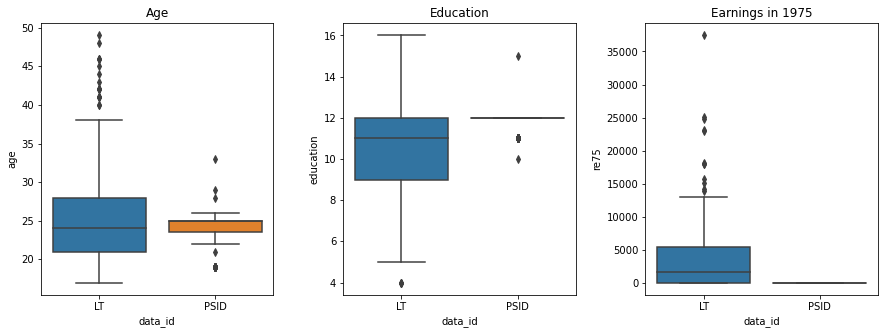

In [40]:
# Boxplots
fn_boxplots(df = df_matched_treat, re74 = False)

Surprisingly, Random Forest fails to make treatment and control groups comparable.

DW dataset

In [41]:
X, T = fn_generate_variables(outcome = None, df = df_DWT_CPS)

phat_RF_DWT_CPS = fn_propensity_score(X, T, method = 'RF', param_grid = param_grid)

df_matched = fn_generate_df_matched(df = df_DWT_CPS, prop = phat_RF_DWT_CPS, outcome = 'dif',
                                    n_neighbors = 1, caliper = np.inf)

df_matched_treat = fn_generate_df_matched_treat(df_matched = df_matched, treat_id = 'DWT')
fn_mean_by_group(df_matched_treat = df_matched_treat, treat_id = 'DWT')

data_id,CPS,DWT
treat,0.000000,1.000000
age,18.348315,25.764045
education,10.241573,10.359551
black,0.966292,0.837079
hispanic,0.000000,0.061798
married,0.022472,0.196629
nodegree,0.915730,0.696629
re75,0.000000,1592.304679
re78,731.665633,6542.764975
re74,379.459366,2177.983895


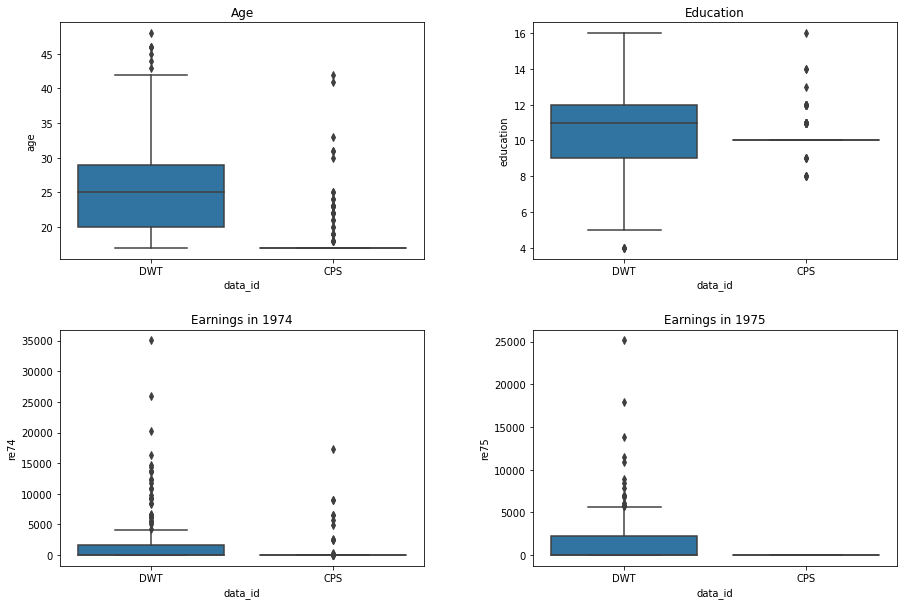

In [42]:
# Boxplots
fn_boxplots(df = df_matched_treat, re74 = True)

In [43]:
X, T = fn_generate_variables(outcome = None, df = df_DWT_PSID)

phat_RF_DWT_PSID = fn_propensity_score(X, T, method = 'RF', param_grid = param_grid)

df_matched = fn_generate_df_matched(df = df_DWT_PSID, prop = phat_RF_DWT_PSID, outcome = 'dif',
                                    n_neighbors = 1, caliper = np.inf)

df_matched_treat = fn_generate_df_matched_treat(df_matched = df_matched, treat_id = 'DWT')
fn_mean_by_group(df_matched_treat = df_matched_treat, treat_id = 'DWT')

data_id,DWT,PSID
treat,1.000000,0.000000
age,26.445122,24.774390
education,10.384146,11.731707
black,0.823171,0.987805
hispanic,0.067073,0.000000
married,0.213415,0.060976
nodegree,0.695122,0.256098
re75,1728.233128,0.000000
re78,6404.746999,1487.593105
re74,2363.909349,597.337420


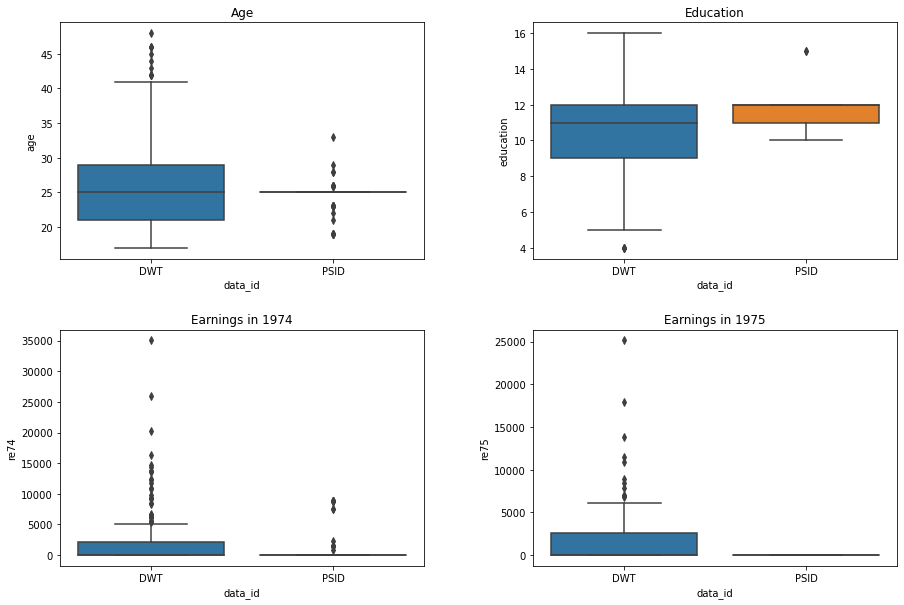

In [44]:
# Boxplots
fn_boxplots(df = df_matched_treat, re74 = True)

Basically the same with LaLonde dataset.

#### 3.2.3 ATE and ATET estimates

In [45]:
param_grid_p = {'n_estimators': [50, 100, 500, 1000],
                'max_features': [2, 3, 4, 5]}
param_grid_mu = {'n_estimators': [50, 100, 500, 1000],
                 'max_features': [2, 3, 4, 5]}

df_results = fn_generate_df_results(df = df, param_grid_p = param_grid_p, param_grid_mu = param_grid_mu)

100%|████████████████████████████████████████████████████████████████████████████████| 2/2 [2:49:35<00:00, 5087.76s/it]


In [46]:
PSM_summary = fn_pick_results(df_results, method = 'PSM')
PSM_summary[PSM_summary.Outcome == 'dif'].reset_index(drop = True)

,Outcome,Treatment,Control,Method,Est_Prop,ATE,ATET
0,dif,LT,CPS,PSM,logit,-2122.159242,-142.154448
1,dif,LT,CPS,PSM,RF,6954.276115,2482.696058
2,dif,LT,CPS,PSM,GB,-1269.748110,-1507.176730
3,dif,LT,PSID,PSM,logit,-3094.999675,-669.771060
4,dif,LT,PSID,PSM,RF,5368.636902,788.037132
5,dif,LT,PSID,PSM,GB,-1779.832846,-1380.062615
6,dif,DWT,CPS,PSM,logit,1294.610131,650.086686
7,dif,DWT,CPS,PSM,RF,7119.566201,4367.907995
8,dif,DWT,CPS,PSM,GB,1988.773688,1621.932216
9,dif,DWT,PSID,PSM,logit,-461.855669,776.036224


In [47]:
PSM_summary[PSM_summary.Outcome == 're78'].reset_index(drop = True)

,Outcome,Treatment,Control,Method,Est_Prop,ATE,ATET
0,re78,LT,CPS,PSM,logit,-889.828448,-366.189363
1,re78,LT,CPS,PSM,RF,3722.119805,5592.789588
2,re78,LT,CPS,PSM,GB,-1098.218475,-588.125017
3,re78,LT,PSID,PSM,logit,-1589.727296,-1043.150675
4,re78,LT,PSID,PSM,RF,1493.707987,4277.729378
5,re78,LT,PSID,PSM,GB,-3509.861818,-662.849576
6,re78,DWT,CPS,PSM,logit,1199.540079,758.581889
7,re78,DWT,CPS,PSM,RF,4876.358489,5969.208745
8,re78,DWT,CPS,PSM,GB,1317.323116,2135.445330
9,re78,DWT,PSID,PSM,logit,-129.761621,174.346387


### 3.3 Inverse Probability of Treatment Weighted (IPTW) Estimator

#### 3.3.1 Estimate propensity score by logistic regression

In [48]:
IPTW_summary = fn_pick_results(df_results, method = 'IPTW')
IPTW_summary[IPTW_summary.Est_Prop == 'logit'].reset_index(drop = True)

,Outcome,Treatment,Control,Method,Est_Prop,ATE
0,dif,LT,CPS,IPTW,logit,-2779.761998
1,dif,LT,PSID,IPTW,logit,-5954.985771
2,dif,DWT,CPS,IPTW,logit,-192.714901
3,dif,DWT,PSID,IPTW,logit,-1076.628815
4,re78,LT,CPS,IPTW,logit,-1634.390493
5,re78,LT,PSID,IPTW,logit,-2196.506472
6,re78,DWT,CPS,IPTW,logit,-1008.058240
7,re78,DWT,PSID,IPTW,logit,-2806.561656


#### 3.3.2 Estimate propensity score by Random Forest

In [49]:
IPTW_summary[IPTW_summary.Est_Prop == 'RF'].reset_index(drop = True)

,Outcome,Treatment,Control,Method,Est_Prop,ATE
0,dif,LT,CPS,IPTW,RF,-1035.757318
1,dif,LT,PSID,IPTW,RF,-1915.618797
2,dif,DWT,CPS,IPTW,RF,-1101.491182
3,dif,DWT,PSID,IPTW,RF,-1436.295796
4,re78,LT,CPS,IPTW,RF,-4142.798296
5,re78,LT,PSID,IPTW,RF,-5695.350332
6,re78,DWT,CPS,IPTW,RF,-3317.300434
7,re78,DWT,PSID,IPTW,RF,-5960.908301


#### 3.3.3 Estimate propensity score by Gradient Boosting

In [50]:
IPTW_summary[IPTW_summary.Est_Prop == 'GB'].reset_index(drop = True)

,Outcome,Treatment,Control,Method,Est_Prop,ATE
0,dif,LT,CPS,IPTW,GB,-2319.833092
1,dif,LT,PSID,IPTW,GB,-3767.388029
2,dif,DWT,CPS,IPTW,GB,-1216.284100
3,dif,DWT,PSID,IPTW,GB,-238.041574
4,re78,LT,CPS,IPTW,GB,-1074.836246
5,re78,LT,PSID,IPTW,GB,-7912.901504
6,re78,DWT,CPS,IPTW,GB,-438.211696
7,re78,DWT,PSID,IPTW,GB,1299.098019


### 3.4 Doubly Robust Estimator

#### 3.4.1 Estimate $\mu_1(X)$ and $\mu_0(X)$ by Random Forest

In [51]:
DR_summary = fn_pick_results(df_results, method = 'DR')
DR_summary[(DR_summary.Outcome == 'dif') & (DR_summary.Est_Imput == 'RF')].reset_index(drop = True)

,Outcome,Treatment,Control,Method,Est_Prop,Est_Imput,ATE
0,dif,LT,CPS,DR,logit,RF,-1082.167710
1,dif,LT,CPS,DR,RF,RF,-255.807581
2,dif,LT,CPS,DR,GB,RF,-588.887524
3,dif,LT,PSID,DR,logit,RF,-3135.306290
4,dif,LT,PSID,DR,RF,RF,-2245.285259
5,dif,LT,PSID,DR,GB,RF,-2906.402161
6,dif,DWT,CPS,DR,logit,RF,827.326364
7,dif,DWT,CPS,DR,RF,RF,1315.768043
8,dif,DWT,CPS,DR,GB,RF,100.200163
9,dif,DWT,PSID,DR,logit,RF,-315.063232


In [52]:
DR_summary[(DR_summary.Outcome == 're78') & (DR_summary.Est_Imput == 'RF')].reset_index(drop = True)

,Outcome,Treatment,Control,Method,Est_Prop,Est_Imput,ATE
0,re78,LT,CPS,DR,logit,RF,-775.495686
1,re78,LT,CPS,DR,RF,RF,-267.845231
2,re78,LT,CPS,DR,GB,RF,-745.703861
3,re78,LT,PSID,DR,logit,RF,-2816.792834
4,re78,LT,PSID,DR,RF,RF,-3357.591736
5,re78,LT,PSID,DR,GB,RF,-4044.339813
6,re78,DWT,CPS,DR,logit,RF,870.608148
7,re78,DWT,CPS,DR,RF,RF,1287.539204
8,re78,DWT,CPS,DR,GB,RF,184.760123
9,re78,DWT,PSID,DR,logit,RF,-666.669290


#### 3.4.2 Estimate $\mu_1(X)$ and $\mu_0(X)$ by Gradient Boosting

In [53]:
DR_summary[(DR_summary.Outcome == 'dif') & (DR_summary.Est_Imput == 'GB')].reset_index(drop = True)

,Outcome,Treatment,Control,Method,Est_Prop,Est_Imput,ATE
0,dif,LT,CPS,DR,logit,GB,-957.491661
1,dif,LT,CPS,DR,RF,GB,-629.696234
2,dif,LT,CPS,DR,GB,GB,-1097.459249
3,dif,LT,PSID,DR,logit,GB,-4988.690569
4,dif,LT,PSID,DR,RF,GB,-2352.703521
5,dif,LT,PSID,DR,GB,GB,-4019.313530
6,dif,DWT,CPS,DR,logit,GB,667.640594
7,dif,DWT,CPS,DR,RF,GB,977.726316
8,dif,DWT,CPS,DR,GB,GB,-530.172744
9,dif,DWT,PSID,DR,logit,GB,-415.959083


In [54]:
DR_summary[(DR_summary.Outcome == 're78') & (DR_summary.Est_Imput == 'GB')].reset_index(drop = True)

,Outcome,Treatment,Control,Method,Est_Prop,Est_Imput,ATE
0,re78,LT,CPS,DR,logit,GB,-849.600899
1,re78,LT,CPS,DR,RF,GB,-501.426052
2,re78,LT,CPS,DR,GB,GB,-1237.715357
3,re78,LT,PSID,DR,logit,GB,-4433.308384
4,re78,LT,PSID,DR,RF,GB,-3188.058286
5,re78,LT,PSID,DR,GB,GB,-4221.955379
6,re78,DWT,CPS,DR,logit,GB,375.558485
7,re78,DWT,CPS,DR,RF,GB,734.145998
8,re78,DWT,CPS,DR,GB,GB,-474.566720
9,re78,DWT,PSID,DR,logit,GB,-314.340214


In [55]:
# treatment_names = ['LT','DWT']
# control_names = ['CPS','PSID']
# outcome_names = ['dif','re78']
# method_names = ['logit','RF']
# param_grid = {'n_estimators': [50, 100, 500, 1000],
#               'max_features': [2, 3, 4, 5]}

# estdict = {}
# for treat in treatment_names:
#     for control in control_names:
#         for outcome in outcome_names:
#             for method in method_names:
#                 phat_logit = fn_PS_summary(treat_id = treat, control_id = control, df = df, 
#                                         outcome = outcome, method = method, param_grid = param_grid)
#                 name = treat + '~' + control + '~' + outcome + '~' + method
#                 estdict[name] = {'phat_logit': phat_logit}

In [56]:
# PSM_summary = np.zeros
# PSM_summary = np.zeros([16,7])
# PSM_summary = pd.DataFrame(PSM_summary)
# PSM_summary.columns = ['Estimate Method','Treat_id','Control_id','Outcome','method', 'ATET', 'ATE']

In [57]:
# n_neighbors = 1
# caliper = np.inf

# Estimator = 'PSM'
# treatment_names = ['LT','DWT']
# control_names = ['CPS','PSID']
# outcome_names = ['dif','re78']
# method_names = ['logit','RF']
# param_grid = {'n_estimators': [50, 100, 500, 1000],
#               'max_features': [2, 3, 4, 5]}

# summary_all = []
# for treat in treatment_names:
#     for control in control_names:
#         for outcome in outcome_names:
#             for method in method_names:
#                 name = treat + '~' + control + '~' + outcome + '~' + method
#                 phat_logit = estdict[name]['phat_logit']
#                 summary = fn_Estimator_summary(Estimator = Estimator, prop = phat_logit, treat_id = treat, control_id = control, 
#                                                df = df, outcome = outcome, method = method, n_neighbors = n_neighbors, 
#                                                caliper = caliper, param_grid = param_grid)
#                 summary_all.append(summary)

# for i in range(len(PSM_summary)):
#     PSM_summary.iloc[i] = summary_all[i]
# PSM_summary

In [58]:
# IPTW_summary = np.zeros
# IPTW_summary = np.zeros([16,6])
# IPTW_summary = pd.DataFrame(IPTW_summary)
# IPTW_summary.columns = ['Estimator','Treat_id','Control_id','Outcome','method','ATE']

In [59]:
# n_neighbors = 1
# caliper = np.inf

# Estimator = 'IPTW'
# treatment_names = ['LT','DWT']
# control_names = ['CPS','PSID']
# outcome_names = ['dif','re78']
# method_names = ['logit','RF']
# param_grid = {'n_estimators': [50, 100, 500, 1000],
#               'max_features': [2, 3, 4, 5]}

# summary_all = []
# for treat in treatment_names:
#     for control in control_names:
#         for outcome in outcome_names:
#             for method in method_names:
#                 name = treat + '~' + control + '~' + outcome + '~' + method
#                 phat_logit = estdict[name]['phat_logit']
#                 summary = fn_Estimator_summary(Estimator = Estimator, prop = phat_logit, treat_id = treat, control_id = control, 
#                                                df = df, outcome = outcome, method = method, n_neighbors = n_neighbors, 
#                                                caliper = caliper, param_grid = param_grid)
#                 summary_all.append(summary)

# for i in range(len(IPTW_summary)):
#     IPTW_summary.iloc[i] = summary_all[i]
# IPTW_summary

In [60]:
# DRE_summary = np.zeros
# DRE_summary = np.zeros([16,7])
# DRE_summary = pd.DataFrame(DRE_summary)
# DRE_summary.columns = ['Estimator','Treat_id','Control_id','Outcome','method_PS','method_mu','ATE']

In [61]:
# n_neighbors = 1
# caliper = np.inf

# Estimator = 'DRE'
# treatment_names = ['LT','DWT']
# control_names = ['CPS','PSID']
# outcome_names = ['dif','re78']
# method_names = ['RF']
# method_mu_names = ['RF','GB']
# param_grid = {'n_estimators': [50, 100, 500, 1000],
#               'max_features': [2, 3, 4, 5]}
# param_grid_mu = param_grid

# summary_all = []
# for treat in treatment_names:
#     for control in control_names:
#         for outcome in outcome_names:
#             for method in method_names:
#                 for method_mu in method_mu_names:
#                     name = treat + '~' + control + '~' + outcome + '~' + method
#                     phat_logit = estdict[name]['phat_logit']
#                     summary = fn_Estimator_summary(Estimator = Estimator, prop = phat_logit, treat_id = treat, control_id = control, 
#                                                    df = df, outcome = outcome, method = method, n_neighbors = n_neighbors, 
#                                                    caliper = caliper, param_grid = param_grid, method_mu = method_mu, param_grid_mu = param_grid_mu)
#                     summary_all.append(summary)

# for i in range(len(DRE_summary)):
#     DRE_summary.iloc[i] = summary_all[i]
# DRE_summary

## 4. Findings

a. What are your main findings?  
b. Are your findings robust to different model specifications?

The first table shows the results of treatment effect estimated by linear regression model. The experimental treatment effects ranges from 798 to 886 for Lalonde data, and ranges from 1375 to 1794 for Dehejia and Wahba data, considering different specifications and outcome variable. 

Overall, the regression results of the non-experiment data fail to generate similar results of experiment results neither for Lalonde's data nor for DW's data, where the closest one differs more than 400 from the true. In addition, the non-experiment treatment effects are very sensitive to the outcome variable, they are mostly positive when outcome variable is 're78 - re75' but mostly negative when it is 're78'. In addition, they are also sensitive to the covariates that we control. The ranges are more than 1000 when outcome variable is 're78 - re75' and are more than 4000 when it is 're78'.


In [62]:
reg_summary_dif

,Outcome,Treatment,Control,Without control,With age,With all control
0,dif,LT,LC,846.888287,856.910955,819.277091
1,dif,LT,CPS,1714.397705,195.174602,237.651169
2,dif,LT,PSID,419.670577,-749.207210,-443.676772
3,dif,DWT,DWC,1529.196083,1516.996931,1375.151605
4,dif,DWT,CPS,3621.232061,2383.311533,2490.625993
5,dif,DWT,PSID,2326.504934,1256.927930,1724.284500


In [63]:
reg_summary_re78

,Outcome,Treatment,Control,Without control,With age,With all control
0,re78,LT,LC,886.303722,881.739626,798.351154
1,re78,LT,CPS,-8870.307627,-7172.308044,-4416.211594
2,re78,LT,PSID,-15577.568900,-13267.657059,-8067.322113
3,re78,DWT,DWC,1794.342382,1736.057724,1672.426452
4,re78,DWT,CPS,-8497.516148,-7274.306837,-4416.872715
5,re78,DWT,PSID,-15204.777421,-13268.950367,-7741.075140


The second and third table shows the results of treatment effect estimated by Random Forest Regression and Gradient Boosting Regression. The main finding is that PSID control group could generate similar treatment effect as the experiment data does for the Lalonde data when the outcome variable is 're78 - re75'. Their difference is only about 70 under both method, while the difference is more than 700 for the DW's data. It somehow provides the support for the conjecture that the linear specification may be wrong when estimating the non-experiment treatment effect.

In [64]:
RF_summary

,Outcome,Treatment,Control,Method,Est_Imput,ATE
0,dif,LT,LC,Regression,RF,1050.745880
1,dif,LT,CPS,Regression,RF,2827.125271
2,dif,LT,PSID,Regression,RF,677.994351
3,dif,DWT,DWC,Regression,RF,1192.891451
4,dif,DWT,CPS,Regression,RF,4147.130516
5,dif,DWT,PSID,Regression,RF,2421.435178
6,re78,LT,LC,Regression,RF,995.759953
7,re78,LT,CPS,Regression,RF,-3669.878382
8,re78,LT,PSID,Regression,RF,-7809.572183
9,re78,DWT,DWC,Regression,RF,1495.568156


In [65]:
GB_summary

,Outcome,Treatment,Control,Method,Est_Imput,ATE
0,dif,LT,LC,Regression,GB,769.596407
1,dif,LT,CPS,Regression,GB,2168.816546
2,dif,LT,PSID,Regression,GB,615.406169
3,dif,DWT,DWC,Regression,GB,1189.304675
4,dif,DWT,CPS,Regression,GB,3646.448022
5,dif,DWT,PSID,Regression,GB,2587.054168
6,re78,LT,LC,Regression,GB,696.425647
7,re78,LT,CPS,Regression,GB,-4141.430741
8,re78,LT,PSID,Regression,GB,-7781.724026
9,re78,DWT,DWC,Regression,GB,1363.019006


The fourth table shows the results of treatment effect estimated by Propensity Score Matching, where it uses logit regression or random forest to estimate the propensity score. For the Lalonde data, the treatment effect remains negative if it uses logit regression to estimate the propensity score. The main finding here is that CPS control group, given the outcome variable 're78 - re75' and random forest method to estimate the propensity score, could generate 794 average treatment effect on the treated, which is very close to the true treatment effect 819 estimated by linear regression and 793 estimated by Gradient Boosting.

On the other hand, for the DW data, the treatment effects are all positive, but are at least 1000 larger than the true effect if it uses random forest to estimate the propensity score. The main finding in DW data here is that if it uses logit regression to estimate the propensity score, CPS control group could generate 1324 average treatment effect when the outcome variable is 're78 - re75' and 1229 average treatment effect when the outcome variable is 're78', they are very close to true treatment effect 1375 estimated by linear regression, 1335 estimated by Random Forest and 1124 estimated by Gradient Boosting.

Overall, when it uses propensity score matching to estimate the non-experimental treatment effect, CPS group could provide similar results as the experimental treatment effect under the condition that estimation method and outcome variable are correctly specified.

In [66]:
PSM_summary

,Outcome,Treatment,Control,Method,Est_Prop,ATE,ATET
0,dif,LT,CPS,PSM,logit,-2122.159242,-142.154448
1,dif,LT,CPS,PSM,RF,6954.276115,2482.696058
2,dif,LT,CPS,PSM,GB,-1269.748110,-1507.176730
3,dif,LT,PSID,PSM,logit,-3094.999675,-669.771060
4,dif,LT,PSID,PSM,RF,5368.636902,788.037132
5,dif,LT,PSID,PSM,GB,-1779.832846,-1380.062615
6,dif,DWT,CPS,PSM,logit,1294.610131,650.086686
7,dif,DWT,CPS,PSM,RF,7119.566201,4367.907995
8,dif,DWT,CPS,PSM,GB,1988.773688,1621.932216
9,dif,DWT,PSID,PSM,logit,-461.855669,776.036224


The fifth table shows the results of treatment effect estimated by Inverse Probability of Treatment Weighted. All of the average treatment effect estimated by this method remain negative. Therefore, it concludes that this method is not an appropriate one to estimate the non-experiment treatment effect.

In [67]:
IPTW_summary

,Outcome,Treatment,Control,Method,Est_Prop,ATE
0,dif,LT,CPS,IPTW,logit,-2779.761998
1,dif,LT,CPS,IPTW,RF,-1035.757318
2,dif,LT,CPS,IPTW,GB,-2319.833092
3,dif,LT,PSID,IPTW,logit,-5954.985771
4,dif,LT,PSID,IPTW,RF,-1915.618797
5,dif,LT,PSID,IPTW,GB,-3767.388029
6,dif,DWT,CPS,IPTW,logit,-192.714901
7,dif,DWT,CPS,IPTW,RF,-1101.491182
8,dif,DWT,CPS,IPTW,GB,-1216.284100
9,dif,DWT,PSID,IPTW,logit,-1076.628815


The last table shows the results of treatment effect estimated by Doubly Robust Estimation. It still remain negative for all the average treatment effect in the Lalonde data and for the average treatment effect using PSID control group in the DW data. The main finding here is that CPS control group in the DW data could generate similar result as the true treatment effect, especially when it uses random forest to estimate $\mu$. It generates 1233 when 're78 - re75' works as the outcome variable and 1253 when 're78' does, and they are very close to true treatment effect 1375 estimated by linear regression, 1335 estimated by Random Forest and 1124 estimated by Gradient Boosting.

In [68]:
DR_summary

,Outcome,Treatment,Control,Method,Est_Prop,Est_Imput,ATE
0,dif,LT,CPS,DR,logit,RF,-1082.167710
1,dif,LT,CPS,DR,logit,GB,-957.491661
2,dif,LT,CPS,DR,RF,RF,-255.807581
3,dif,LT,CPS,DR,RF,GB,-629.696234
4,dif,LT,CPS,DR,GB,RF,-588.887524
5,dif,LT,CPS,DR,GB,GB,-1097.459249
6,dif,LT,PSID,DR,logit,RF,-3135.306290
7,dif,LT,PSID,DR,logit,GB,-4988.690569
8,dif,LT,PSID,DR,RF,RF,-2245.285259
9,dif,LT,PSID,DR,RF,GB,-2352.703521


In conclusion, this paper conducts several estimation methods to investigate the non-experiment treatment effect with the CPS and PSID data. Although it finds that under some conditions that the non-experiment data could generate similar results as the experiment data does, the results are very sensitive to the outcome variable, the estimation method and the control group. Therefore, it should be cautious to reach the conclusion that we can estimate casual effects in NSW using non-experiment data.

In the Propensity Score Matching estimation, it could generate similar results for Lalonde data and DW data that CPS control group could replicate the true treatment, with only the exception that they need to use different method to estimate the propensity score. However, the results differ between Lalonde and DW data in other estimation strategies.
PSID could replicate the results for Lalonde data in the Random Forest Regression and Gradient Boosting Regression, while CPS does for DW data in the Doubly Robust Estimation. 

Overall, this results could somehow provide support for Dehejia and Wahba(1999) and Dehejia and Wahba(2002) that propensity score matching estimation could alleviate the bias due to systematic differences between the treated and comparison units and replicate the causal effect in NSW with non-experiment dataset.



## 5. Conclusion

a. Discuss what we’ve learned from your analysis.  
b. Discuss any questions that could be answered in the future.

## Endnotes

<a name="cite_note-1"></a>1. [^](#cite_ref-1) Aid to Families with Dependent Children.

## References

1. Dehejia, R., & Wahba, S. (1999). Causal effects in nonexperimental studies: Reevaluating the evaluation of training programs. *Journal of the American Statistical Association*, 94(448), 1053&ndash;1062.  
2. Dehejia, R., & Wahba, S. (2002). Propensity score-matching methods for nonexperimental causal studies. *Review of Economics and Statistics*, 84(1), 151&ndash;161.  
3. LaLonde, R. (1986). Evaluating the econometric evaluations of training programs with experimental data. *American Economic Review*, 76(4), 604&ndash;620.  
4. Smith, J. A., & Todd, P. E. (2005). Does matching overcome LaLonde’s critique of nonexperimental estimators? *Journal of Econometrics*, 125(1–2), 305&ndash;353.  